<a href="https://colab.research.google.com/github/SumathiGit/Image-Captioning-Pytorch/blob/main/captioning_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Part of the code is borrowed from https://colab.research.google.com/drive/1vzrxDYB0vxtuUy8KCaGxm--nDCJvyBSg#scrollTo=HRUp0r_-B9N0&forceEdit=true&sandboxMode=true

In [1]:
# Instal captioning repo and download the transformer pretrained model
%pip install git+https://github.com/ruotianluo/ImageCaptioning.pytorch.git
%pip install gdown
# !gdown --id 1KvRXqfVEXbCGj2LapfQ3py6bLjW9FatB
# !gdown --id 1Rsw1XukVghaaQt7TSrjNogu7_8Kp3n7G
!gdown --id 1VmUzgu0qlmCMqM1ajoOZxOXP3hiC_qlL
!gdown --id 1zQe00W02veVYq-hdq5WsPOS3OPkNdq79

  Cloning https://github.com/ruotianluo/ImageCaptioning.pytorch.git to /tmp/pip-req-build-1wng8dct
  Running command git clone -q https://github.com/ruotianluo/ImageCaptioning.pytorch.git /tmp/pip-req-build-1wng8dct
  Running command git submodule update --init --recursive -q
  Created wheel for captioning: filename=captioning-0.0.1-cp37-none-any.whl size=66951 sha256=f857f1eb0147ef96c84cce76e1bc979f1565641f5a5cbebc8e279438b0ea655b
  Stored in directory: /tmp/pip-ephem-wheel-cache-8_nii6c5/wheels/b2/ba/12/45bfbc14a95e13bb06a04bfdca0b07afe2375539f741fae716
Successfully built captioning
Downloading...
From: https://drive.google.com/uc?id=1VmUzgu0qlmCMqM1ajoOZxOXP3hiC_qlL
To: /content/model-best.pth
230MB [00:06, 37.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zQe00W02veVYq-hdq5WsPOS3OPkNdq79
To: /content/infos_trans12-best.pkl
100% 777k/777k [00:00<00:00, 6.79MB/s]


In [2]:
!pip install yacs

In [3]:
# Install maskrcnn-benchmark to extract detectron features
%cd /content
!git clone https://gitlab.com/vedanuj/vqa-maskrcnn-benchmark.git
%cd /content/vqa-maskrcnn-benchmark
# Compile custom layers and build mask-rcnn backbone
!python setup.py build
!python setup.py develop
import sys
sys.path.append('/content/vqa-maskrcnn-benchmark')

/content
Cloning into 'vqa-maskrcnn-benchmark'...
remote: Enumerating objects: 764, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 764 (delta 122), reused 128 (delta 107), pack-reused 602
Receiving objects: 100% (764/764), 3.77 MiB | 27.61 MiB/s, done.
Resolving deltas: 100% (409/409), done.
/content/vqa-maskrcnn-benchmark
running build
running build_py
creating build
creating build/lib.linux-x86_64-3.7
creating build/lib.linux-x86_64-3.7/maskrcnn_benchmark
copying maskrcnn_benchmark/__init__.py -> build/lib.linux-x86_64-3.7/maskrcnn_benchmark
creating build/lib.linux-x86_64-3.7/maskrcnn_benchmark/data
copying maskrcnn_benchmark/data/build.py -> build/lib.linux-x86_64-3.7/maskrcnn_benchmark/data
copying maskrcnn_benchmark/data/collate_batch.py -> build/lib.linux-x86_64-3.7/maskrcnn_benchmark/data
copying maskrcnn_benchmark/data/__init__.py -> build/lib.linux-x86_64-3.7/maskrcnn_benchmark/data
creating build/lib.linux

In [4]:
pwd

'/content/vqa-maskrcnn-benchmark'

In [5]:
!ls

ABSTRACTIONS.md     demo			 MODEL_ZOO.md
build		    docker			 README.md
CODE_OF_CONDUCT.md  INSTALL.md			 setup.py
configs		    LICENSE			 tests
CONTRIBUTING.md     maskrcnn_benchmark		 tools
create_json.py	    maskrcnn_benchmark.egg-info  TROUBLESHOOTING.md


In [6]:
# Download the models for feature extraction
%cd /content/

%mkdir model_data
# !wget -O /content/model_data/detectron_model.pth  https://dl.fbaipublicfiles.com/pythia/detectron_model/detectron_model.pth 
# !wget -O /content/model_data/detectron_model.yaml https://dl.fbaipublicfiles.com/pythia/detectron_model/detectron_model.yaml

!wget -O /content/model_data/detectron_model.pth wget https://dl.fbaipublicfiles.com/vilbert-multi-task/detectron_model.pth
!wget -O /content/model_data/detectron_model.yaml wget https://dl.fbaipublicfiles.com/vilbert-multi-task/detectron_config.yaml

/content
--2021-07-17 05:04:57--  http://wget/
Resolving wget (wget)... failed: Name or service not known.
wget: unable to resolve host address ‘wget’
--2021-07-17 05:04:57--  https://dl.fbaipublicfiles.com/vilbert-multi-task/detectron_model.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1661519645 (1.5G) [application/octet-stream]
Saving to: ‘/content/model_data/detectron_model.pth’

/content/model_data 100%[===================>]   1.55G  76.8MB/s    in 21s     

2021-07-17 05:05:19 (73.9 MB/s) - ‘/content/model_data/detectron_model.pth’ saved [1661519645/1661519645]

FINISHED --2021-07-17 05:05:19--
Total wall clock time: 22s
Downloaded: 1 files, 1.5G in 21s (73.9 MB/s)
--2021-07-17 05:05:19--  http://wget/
Resolving wget (wget)... failed: Name or service not known.
wget: unab

In [8]:
import yaml
import cv2
import torch
import requests
import numpy as np
import gc
import torch.nn.functional as F
import pandas as pd


import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
from IPython.display import display, HTML, clear_output
from ipywidgets import widgets, Layout
from io import BytesIO


from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.layers import nms
from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.structures.image_list import to_image_list
from maskrcnn_benchmark.utils.model_serialization import load_state_dict


class FeatureExtractor:
  TARGET_IMAGE_SIZE = [448, 448]
  CHANNEL_MEAN = [0.485, 0.456, 0.406]
  CHANNEL_STD = [0.229, 0.224, 0.225]
  
  def __init__(self):
    # self._init_processors()
    self.detection_model = self._build_detection_model()
  
  def __call__(self, url):
    with torch.no_grad():
      detectron_features = self.get_detectron_features(url)
    
    return detectron_features
  
  def _build_detection_model(self):

      cfg.merge_from_file('/content/model_data/detectron_model.yaml')
      cfg.freeze()

      model = build_detection_model(cfg)
      checkpoint = torch.load('/content/model_data/detectron_model.pth', 
                              map_location=torch.device("cpu"))

      load_state_dict(model, checkpoint.pop("model"))

      model.to("cuda")
      model.eval()
      return model
  
  def get_actual_image(self, image_path):
      if image_path.startswith('http'):
          path = requests.get(image_path, stream=True).raw
      else:
          path = image_path
      
      return path

  def _image_transform(self, image_path):
      path = self.get_actual_image(image_path)

      img = Image.open(path)
      im = np.array(img).astype(np.float32)
      im = im[:, :, ::-1]
      im -= np.array([102.9801, 115.9465, 122.7717])
      im_shape = im.shape
      im_size_min = np.min(im_shape[0:2])
      im_size_max = np.max(im_shape[0:2])
      im_scale = float(800) / float(im_size_min)
      # Prevent the biggest axis from being more than max_size
      if np.round(im_scale * im_size_max) > 1333:
           im_scale = float(1333) / float(im_size_max)
      im = cv2.resize(
           im,
           None,
           None,
           fx=im_scale,
           fy=im_scale,
           interpolation=cv2.INTER_LINEAR
       )
      img = torch.from_numpy(im).permute(2, 0, 1)
      return img, im_scale


  def _process_feature_extraction(self, output,
                                 im_scales,
                                 feat_name='fc6',
                                 conf_thresh=0.2):
      batch_size = len(output[0]["proposals"])
      n_boxes_per_image = [len(_) for _ in output[0]["proposals"]]
      score_list = output[0]["scores"].split(n_boxes_per_image)
      score_list = [torch.nn.functional.softmax(x, -1) for x in score_list]
      feats = output[0][feat_name].split(n_boxes_per_image)
      cur_device = score_list[0].device

      feat_list = []

      for i in range(batch_size):
          dets = output[0]["proposals"][i].bbox / im_scales[i]
          scores = score_list[i]

          max_conf = torch.zeros((scores.shape[0])).to(cur_device)

          for cls_ind in range(1, scores.shape[1]):
              cls_scores = scores[:, cls_ind]
              keep = nms(dets, cls_scores, 0.5)
              max_conf[keep] = torch.where(cls_scores[keep] > max_conf[keep],
                                           cls_scores[keep],
                                           max_conf[keep])

          keep_boxes = torch.argsort(max_conf, descending=True)[:100]
          feat_list.append(feats[i][keep_boxes])
      return feat_list
    
  def get_detectron_features(self, image_path):
      im, im_scale = self._image_transform(image_path)
      img_tensor, im_scales = [im], [im_scale]
      current_img_list = to_image_list(img_tensor, size_divisible=32)
      current_img_list = current_img_list.to('cuda')
      with torch.no_grad():
          output = self.detection_model(current_img_list)
      feat_list = self._process_feature_extraction(output, im_scales, 
                                                  'fc6', 0.2)
      return feat_list[0]

In [9]:
feature_extractor = FeatureExtractor()

In [10]:
import captioning
import captioning.utils.misc
import captioning.models
infos = captioning.utils.misc.pickle_load(open('infos_trans12-best.pkl', 'rb'))

Hugginface transformers not installed; please visit https://github.com/huggingface/transformers
meshed-memory-transformer not installed; please run `pip install git+https://github.com/ruotianluo/meshed-memory-transformer.git`


In [11]:
infos['opt'].vocab = infos['vocab']

In [12]:
model = captioning.models.setup(infos['opt'])
model.cuda()
model.load_state_dict(torch.load('model-best.pth'))

<All keys matched successfully>

In [13]:
def get_captions(img_feature):
    # Return the 5 captions from beam serach with beam size 5
    return model.decode_sequence(model(img_feature.mean(0)[None], img_feature[None], mode='sample', opt={'beam_size':5, 'sample_method':'beam_search', 'sample_n':5})[0])

Text(value='https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSl19wwdb7cTzcDDV-fxdIk6BnuxmMBO4tovw&usqp=CA…

Button(description='Caption the image!', style=ButtonStyle())

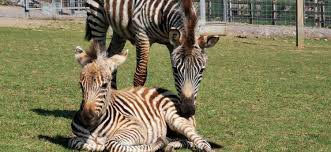

In [23]:
def init_widgets(url):
  image_text = widgets.Text(
    description="Image URL", layout=Layout(minwidth="70%")
  )

  image_text.value = url
  submit_button = widgets.Button(description="Caption the image!")

  display(image_text)
  display(submit_button)

  submit_button.on_click(lambda b: on_button_click(
      b, image_text
  ))
  
  return image_text
  
def on_button_click(b, image_text):
  clear_output()
  image_path = feature_extractor.get_actual_image(image_text.value)
  image = Image.open(image_path)
  
  captions = '<br>'.join(get_captions(feature_extractor(image_text.value)))
  init_widgets(image_text.value)
  display(image)
  
  display(HTML(captions))
 

image_text = init_widgets(
    "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSl19wwdb7cTzcDDV-fxdIk6BnuxmMBO4tovw&usqp=CAU"
)
